In [107]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [108]:
basepath = "food-dataset"
dataset = ["train", "test", "val"]
items = ['Biryani', 'Butter Naan', 'Chai', 'Chole Bhature', 'Dhokla', 'Gulab Jamun', 'Jalebi', 'Momos', 'Paneer Sabzi', 'Pav Bhaji', 'Rasgulla', 'Samosa']

x , y = [] , []
for data in dataset:
    for index, item in enumerate(items):
        path = os.path.join(basepath, data, item)
        try:
            for filename in os.listdir(path):
                filepath = os.path.join(path, filename)
                img = Image.open(filepath).convert("RGB").resize([256,256])
                img_array = np.array(img)
                
                x.append(img_array)
                y.append(index)
                    
        except Exception as e:
            print(f"Error occurred: {e}")


In [109]:
x = np.array(x, dtype="float32").reshape(-1, 256, 256, 3)
x = x / 255.0

y = np.array(y, dtype="int32")


x.shape, y.shape

((4379, 256, 256, 3), (4379,))

In [110]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [111]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape: ", y_test.shape)
print("x_val shape:", x_val.shape)
print("y_val shape: ", y_val.shape)

x_train shape: (2463, 256, 256, 3)
y_train shape: (2463,)
x_test shape: (1095, 256, 256, 3)
y_test shape:  (1095,)
x_val shape: (821, 256, 256, 3)
y_val shape:  (821,)


In [112]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense , BatchNormalization, GlobalMaxPooling2D

In [113]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))

model.add(GlobalMaxPooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(12, activation='softmax'))


In [114]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_30 (Bat  (None, 254, 254, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 127, 127, 64)      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 batch_normalization_31 (Bat  (None, 125, 125, 128)   

In [115]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [116]:
import tensorflow as tf

with tf.device("CPU"): # type: ignore
    x_train = tf.convert_to_tensor(x_train)
    y_train = tf.convert_to_tensor(y_train)
    x_test = tf.convert_to_tensor(x_test)
    y_test = tf.convert_to_tensor(y_test)
    x_val = tf.convert_to_tensor(x_val)
    y_val = tf.convert_to_tensor(y_val)

In [117]:
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True
)


In [123]:
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        
    patience=5,        
    verbose=1
)


In [124]:
history = model.fit(
    x_train, 
    y_train, 
    validation_data =   (x_val, y_val), 
    batch_size      =   8, 
    epochs          =   100, 
    callbacks       =   [early_stop, lr_reduce])

Epoch 1/100
308/308 [==============================] - 31s 101ms/step - loss: 2.7591 - accuracy: 0.1234 - val_loss: 2.4467 - val_accuracy: 0.1157 - lr: 0.0010
Epoch 2/100
308/308 [==============================] - 31s 100ms/step - loss: 2.3902 - accuracy: 0.1539 - val_loss: 2.3879 - val_accuracy: 0.1876 - lr: 0.0010
Epoch 3/100
308/308 [==============================] - 31s 100ms/step - loss: 2.3607 - accuracy: 0.1579 - val_loss: 2.3373 - val_accuracy: 0.1498 - lr: 0.0010
Epoch 4/100
308/308 [==============================] - 31s 100ms/step - loss: 2.3350 - accuracy: 0.1616 - val_loss: 2.3016 - val_accuracy: 0.2010 - lr: 0.0010
Epoch 5/100
308/308 [==============================] - 31s 100ms/step - loss: 2.3316 - accuracy: 0.1770 - val_loss: 2.2709 - val_accuracy: 0.2107 - lr: 0.0010
Epoch 6/100
308/308 [==============================] - 31s 100ms/step - loss: 2.2931 - accuracy: 0.1693 - val_loss: 2.3116 - val_accuracy: 0.1669 - lr: 0.0010
Epoch 7/100
308/308 [=========================

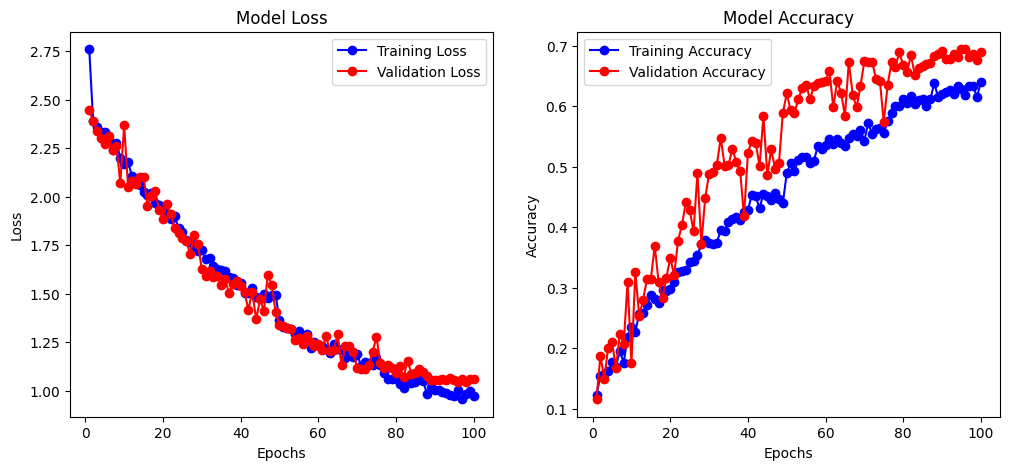

In [125]:
loss = history.history['loss'] # type: ignore
accuracy = history.history['accuracy'] # type: ignore
val_loss = history.history.get('val_loss', None) # type: ignore
val_accuracy = history.history.get('val_accuracy', None) # type: ignore
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
if val_accuracy:
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [126]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=8)
print(f"Test Loss: {test_loss},\n Test Accuracy: {test_accuracy}")

137/137 [==============================] - 3s 19ms/step - loss: 1.0832 - accuracy: 0.6813
Test Loss: 1.083168625831604,
 Test Accuracy: 0.6812785267829895


In [127]:
model.save("food_model_68%.h5")

<===== TESTING =====> 

In [2]:
from tensorflow.keras.models import load_model # type: ignore
from PIL import Image
import numpy as np
import os 

In [ ]:
model = load_model("food_model_83%.h5")

In [4]:
def predict(filepath : str):
   img =  Image.open(filepath).convert("RGB").resize([256,256])
   img_array = np.array(img)
   img_array = np.array(img_array / 255, dtype="float32")
   img_array = np.expand_dims(img_array, axis=0)

   res =  model.predict(img_array)
   predicted_class = np.argmax(res, axis=1)

   items = ['Biryani', 'Butter Naan', 'Chai', 'Chole Bhature', 'Dhokla', 'Gulab Jamun', 'Jalebi', 'Momos', 'Paneer Sabzi', 'Pav Bhaji', 'Rasgulla', 'Samosa']
   class_name = items[predicted_class[0]]

   print("Predicted Class: ", predicted_class[0], " ==> ", class_name)

   return class_name

In [ ]:
while True:
   path = input("Enter the filepath : ")
   if os.path.exists(path):
      pred = predict(path)
      print(f"Model predicted : {pred}")
   else:
       print("File not found")